In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 
from jsbsim_utils import Logger, trim, simulate

Nonlinear-dynamics of aircraft

$$\dot{x} = f(x, u)$$

Find equilibrium:

Minimize $\dot{x}$, or a subset for your problem, by changeing $x_0$, $u_0$

$$0 = f(x_0, u_0)$$

This is an optimization problem.

* Matlab: fmincon, fminsearch
* Python: scipy.minimize (Nelder-Mead, SLSQP)

Can simplify this problem with mixing matrices, to decouple the dynamcis into SISO (single-input-single output) systems.

Due to Taylor series error on the order of (dx^2). We know the linear model approx, does well near the equilibrium point. 

$\dot{\vec{x}} = \vec{f}(x, u) = A \vec{x} + B \vec{u}$

$\dot{\vec{y}} = C \vec{x} + D \vec{u}$


$A = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{x}}$

$B = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{u}}$

$C = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{x}}$

$D = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{u}}$

In [56]:
ct = 0
temp = []
def cost_ground(fdm):
    # modify cost to also penalize throttle   
    udot = fdm['accelerations/udot-ft_sec2']
    vdot = fdm['accelerations/vdot-ft_sec2']
    wdot = fdm['accelerations/wdot-ft_sec2']
    pdot = fdm['accelerations/pdot-rad_sec2']
    qdot = fdm['accelerations/qdot-rad_sec2']
    rdot = fdm['accelerations/rdot-rad_sec2']
    temp.append(fdm.get_property_catalog('fbz'))
    return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2  
        
op_ground, fdm, res = trim(
    aircraft='F-35B-2',
    ic={
        'ic/vt-fps': 0,
        'gear/gear-cmd-norm': 1,
        'propulsion/engine/pitch-angle-rad': np.deg2rad(0),
        'fcs/throttle-cmd-norm': 0,
        'fcs/aileron-cmd-norm': 0,
        'fcs/elevator-cmd-norm': 0,
        'fcs/rudder-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 1,
        'fcs/right-brake-cmd-norm': 1,
        'fcs/center-brake-cmd-norm': 1,
    },
    design_vector=['ic/theta-rad', 'ic/h-agl-ft'],
    x0=[0, 3.5],
    verbose=True,
    method='Nelder-Mead', # works better with ground interaction
    tol=1e-12,
    #bounds=[[np.deg2rad(-40), np.deg2rad(40)], [0, 20]],
    cost=cost_ground,
)

print(res)
print(op_ground)
print(temp[0])
print(temp[-1])

data['res'] = res
data['op_ground'] = op_ground
data['fbz_initial'] = temp[0]
data['fbz_final'] = temp[-1]
all_data = dict()
all_data['groundTrim'] = data

 final_simplex: (array([[0.00749581, 3.11215077],
       [0.00749581, 3.11215077],
       [0.00749581, 3.11215077]]), array([9.04258553e-12, 9.05337049e-12, 9.05337075e-12]))
           fun: 9.04258552713375e-12
       message: 'Optimization terminated successfully.'
          nfev: 182
           nit: 81
        status: 0
       success: True
             x: array([0.00749581, 3.11215077])
{'fun': 9.04258552713375e-12, 'nit': 81, 'nfev': 182, 'status': 0, 'success': True, 'message': 'Optimization terminated successfully.', 'x': array([0.00749581, 3.11215077]), 'final_simplex': (array([[0.00749581, 3.11215077],
       [0.00749581, 3.11215077],
       [0.00749581, 3.11215077]]), array([9.04258553e-12, 9.05337049e-12, 9.05337075e-12]))}
{'ic/vt-fps': 0, 'gear/gear-cmd-norm': 1, 'propulsion/engine/pitch-angle-rad': 0.0, 'fcs/throttle-cmd-norm': 0, 'fcs/aileron-cmd-norm': 0, 'fcs/elevator-cmd-norm': 0, 'fcs/rudder-cmd-norm': 0, 'fcs/left-brake-cmd-norm': 1, 'fcs/right-brake-cmd-norm': 1, '

In [57]:
log_ground = simulate(
    aircraft='F-35B-2',
    op_0=op_ground,
    tf=5,
    realtime=True)

Text(0, 0.5, 'ft, altitude')

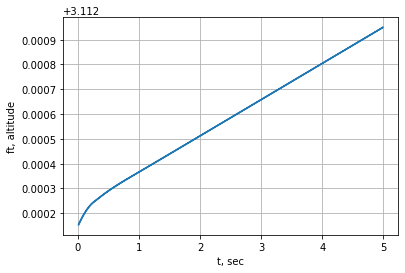

In [58]:
log_ground['position/h-agl-ft'].plot()
plt.grid(True)
plt.ylabel('ft, altitude')

Text(0, 0.5, 'deg, aircraft pitch')

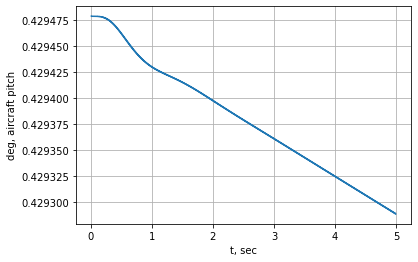

In [59]:
log_ground['attitude/theta-deg'].plot()
plt.grid(True)
plt.ylabel('deg, aircraft pitch')

In [18]:
fdm.resume_integration()
fdm.get_propulsion().get_steady_state()

False

In [60]:
op_hover, fdm, res = trim(
    aircraft='F-35B-2',
    ic={
        'ic/h-agl-ft': 10,
        'ic/vd-fps': 0,
        'ic/vn-fps': 0*np.cos(np.deg2rad(280)),
        'ic/ve-fps': 0*np.sin(np.deg2rad(280)),
        'ic/theta-rad': 0,
        'gear/gear-cmd-norm': 1,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'propulsion/engine/pitch-angle-rad',
        'propulsion/engine[1]/pitch-angle-rad',
        'propulsion/engine[2]/pitch-angle-rad',
        'propulsion/engine[3]/pitch-angle-rad',
    ],
    x0=[0.5, 0, np.deg2rad(90), np.deg2rad(90), np.deg2rad(90), np.deg2rad(90)],
    verbose=True,
    bounds=[[0, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)], 
           [np.deg2rad(0), np.deg2rad(120)],
           [np.deg2rad(0), np.deg2rad(120)],
           [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12
)
print(op_hover)
data1 = dict()
data1['res'] = res
data1['op_hover'] = op_hover
print(fdm.get_property_catalog('dot'))
data1['dot_values'] = fdm.get_property_catalog('dot')

all_data['hoverTrim'] = data1

      fun: 8.855948537345098e-12
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.45794034e-06, -3.74771872e-07, -2.78537761e-07, -3.95065336e-07,
       -2.51641947e-07, -3.76151362e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 259
      nit: 16
     njev: 37
   status: 0
  success: True
        x: array([0.92874054, 0.71683748, 1.57179653, 1.5693725 , 1.57179654,
       1.5693725 ])
{'ic/h-agl-ft': 10, 'ic/vd-fps': 0, 'ic/vn-fps': 0.0, 'ic/ve-fps': -0.0, 'ic/theta-rad': 0, 'gear/gear-cmd-norm': 1, 'fcs/left-brake-cmd-norm': 0, 'fcs/right-brake-cmd-norm': 0, 'fcs/center-brake-cmd-norm': 0, 'fcs/throttle-cmd-norm': 0.9287405445871773, 'fcs/elevator-cmd-norm': 0.7168374772549062, 'propulsion/engine/pitch-angle-rad': 1.5717965316467137, 'propulsion/engine[1]/pitch-angle-rad': 1.5693724982882014, 'propulsion/engine[2]/pitch-angle-rad': 1.5717965408049575, 'propulsion/engine[3]/pitch-angle-rad': 1.5693725005375176}
{'velocities/h

In [14]:
log_hover = simulate(
    aircraft='F-35B-2',
    op_0=op_hover,
    tf=10,
    realtime=True)

Text(0, 0.5, 'ft, altitude')

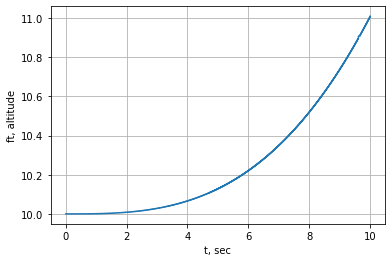

In [46]:
log_hover['position/h-agl-ft'].plot()
plt.grid(True)
plt.ylabel('ft, altitude')

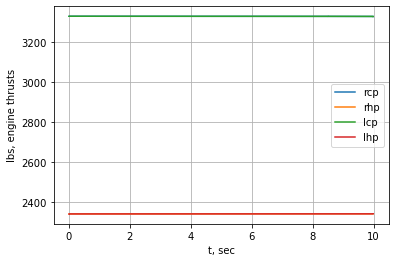

In [47]:
plt.subplot()
log_hover['propulsion/engine/thrust-lbs'].plot()
log_hover['propulsion/engine[1]/thrust-lbs'].plot()
log_hover['propulsion/engine[2]/thrust-lbs'].plot()
log_hover['propulsion/engine[3]/thrust-lbs'].plot()
plt.grid(True)
plt.legend(['rcp', 'rhp', 'lcp', 'lhp'])
plt.ylabel('lbs, engine thrusts')
plt.show()

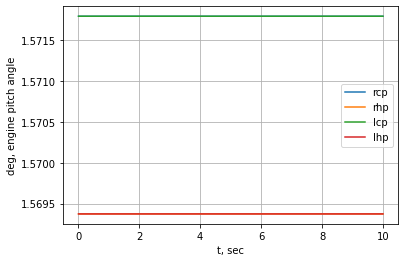

In [48]:
plt.subplot()
log_hover['propulsion/engine/pitch-angle-rad'].plot()
log_hover['propulsion/engine[1]/pitch-angle-rad'].plot()
log_hover['propulsion/engine[2]/pitch-angle-rad'].plot()
log_hover['propulsion/engine[3]/pitch-angle-rad'].plot()
plt.grid(True)
plt.legend(['rcp', 'rhp', 'lcp', 'lhp'])
plt.ylabel('deg, engine pitch angle')
plt.show()

In [61]:
def cost_cruise(fdm):
    # modify cost to also penalize throttle
    delta = fdm['propulsion/engine/pitch-angle-rad']
    theta = fdm['attitude/theta-rad']
    drag = fdm['forces/fwx-aero-lbs']
    lift = fdm['forces/fwz-aero-lbs']
    alpha = fdm['aero/alpha-rad']
    throttle = fdm['fcs/throttle-cmd-norm']
    
    udot = fdm['accelerations/udot-ft_sec2']
    vdot = fdm['accelerations/vdot-ft_sec2']
    wdot = fdm['accelerations/wdot-ft_sec2']
    pdot = fdm['accelerations/pdot-rad_sec2']
    qdot = fdm['accelerations/qdot-rad_sec2']
    rdot = fdm['accelerations/rdot-rad_sec2']
    return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2 - 1e-3*(lift/drag)**2 + 1e-3*(theta < 0) + 1e-1*throttle + 2e-1*delta**2 
        
op_cruise, fdm, res = trim(
    aircraft='F-35B-2',
    ic={
        'ic/gamma-rad': 0,
        'ic/vt-fps': 677,
        'ic/h-agl-ft': 38*1e3,
        'gear/gear-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
        'propulsion/engine/pitch-angle-rad': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'fcs/rudder-cmd-norm',
        'fcs/aileron-cmd-norm',
        'ic/alpha-rad',
        'ic/beta-rad',
        'propulsion/engine/pitch-angle-rad',
    ],
    cost=cost_cruise,
    x0=[0.4, 0, 0, 0, 0, 0, 0],
    verbose=True,
    bounds=[[0, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12,
)
op_cruise

data2 = dict()
data2['res'] = res
data2['op_cruise'] = op_cruise

all_data['cruiseTrim'] = data2

      fun: -0.07279137319063003
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.00000068e-01,  9.11520859e-05, -3.62682107e-05,  6.78235246e-05,
        3.34029193e-03,  2.59819943e-05,  5.21585969e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 760
      nit: 69
     njev: 95
   status: 0
  success: True
        x: array([ 0.        , -0.12367121,  0.00069518, -0.00020624,  0.02021778,
        0.00129227,  0.        ])


In [25]:
log_cruise = simulate(
    aircraft='F-35B-2',
    op_0=op_cruise,
    tf=10,
    realtime=True)

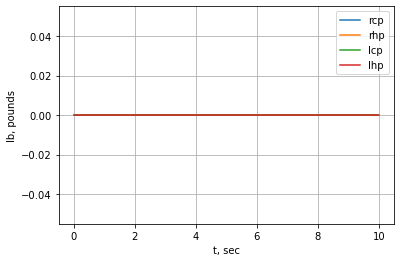

In [30]:
plt.subplot()
log_cruise['propulsion/engine/pitch-angle-rad'].plot()
log_cruise['propulsion/engine[1]/pitch-angle-rad'].plot()
log_cruise['propulsion/engine[2]/pitch-angle-rad'].plot()
log_cruise['propulsion/engine[3]/pitch-angle-rad'].plot()
plt.grid(True)
plt.legend(['rcp', 'rhp', 'lcp', 'lhp'])
plt.ylabel('lb, pounds')
plt.show()

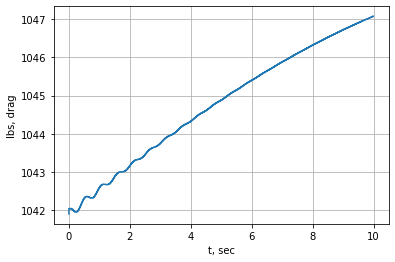

In [34]:
log_cruise['forces/fwx-aero-lbs'].plot()
plt.ylabel('lbs, drag')
plt.grid(True)

Text(0, 0.5, 'lbs, side-force')

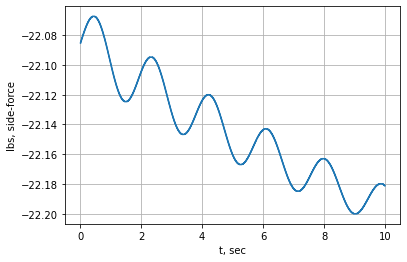

In [37]:
log_cruise['forces/fwy-aero-lbs'].plot()
plt.grid(True)
plt.ylabel('lbs, side-force')

Text(0, 0.5, 'lbs, lift')

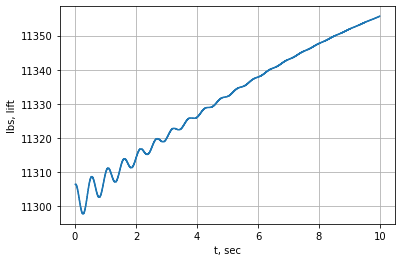

In [36]:
log_cruise['forces/fwz-aero-lbs'].plot()
plt.grid(True)
plt.ylabel('lbs, lift')

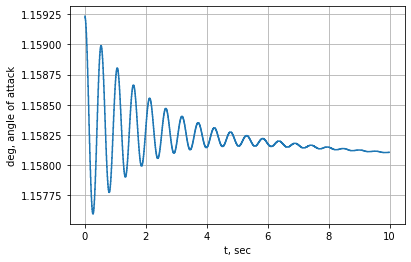

In [43]:
log_cruise['aero/alpha-deg'].plot()
plt.ylabel('deg, angle of attack')
plt.grid(True)

Text(0, 0.5, 'deg, elevator angle')

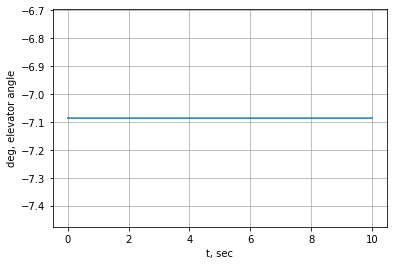

In [41]:
log_cruise['fcs/elevator-pos-deg'].plot()
plt.grid(True)
plt.ylabel('deg, elevator angle')

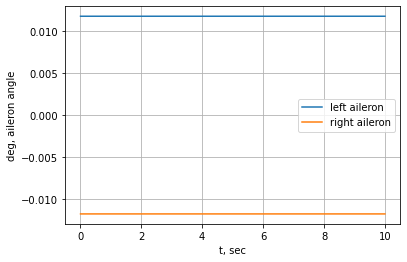

In [40]:
plt.subplot()
log_cruise['fcs/left-aileron-pos-deg'].plot()
log_cruise['fcs/right-aileron-pos-deg'].plot()
plt.grid(True)
plt.legend(['left aileron', 'right aileron'])
plt.ylabel("deg, aileron angle")
plt.show()

Text(0, 0.5, 'deg, rudder angle')

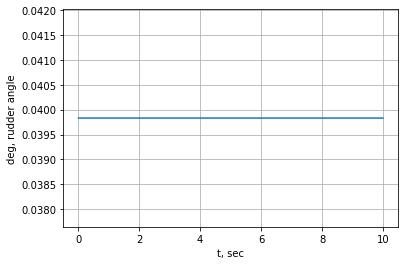

In [42]:
log_cruise['fcs/rudder-pos-deg'].plot()
plt.grid(True)
plt.ylabel('deg, rudder angle')

Text(0, 0.5, 'fps, velocity')

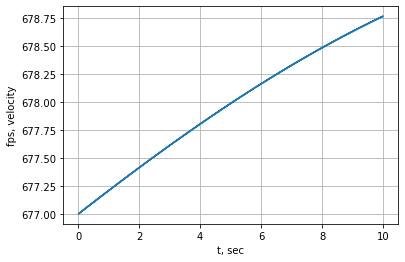

In [85]:
log_cruise['velocities/vt-fps'].plot()
plt.grid(True)
plt.ylabel("fps, velocity")

In [74]:
del all_data['cruiseTrim']['res']['hess_inv']

In [77]:
del all_data['hoverTrim']['res']['hess_inv']

In [81]:
del all_data['cruiseTrim']['res']['message']
del all_data['groundTrim']['res']['message']
del all_data['hoverTrim']['res']['message']

In [82]:
# encode numpy array for JSON serializable
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# save all output as JSON file 
with open('jsbsim_opt.json', '+w') as jfile:
    json.dump(all_data, jfile, indent=4, cls=NumpyEncoder)

,inertial/sea-level-radius_ft,simulation/gravity-model,simulation/integrator/rate/rotational,simulation/integrator/rate/translational,simulation/integrator/position/rotational,simulation/integrator/position/translational,simulation/write-state-file,simulation/channel-dt,simulation/gravitational-torque,simulation/force-output,...,contact/unit[4]/rolling_friction-factor,contact/unit[4]/static-friction-factor,contact/unit[4]/WOW,contact/unit[4]/x-position,contact/unit[4]/y-position,contact/unit[4]/z-position,contact/unit[4]/compression-ft,contact/unit[4]/compression-velocity-fps,contact/unit[4]/static_friction_coeff,contact/unit[4]/dynamic_friction_coeff
"t, sec",,,,,,,,,,,,,,,,,,,,,
0.008333,2.089630e+07,1.0,1.0,3.0,1.0,4.0,0.0,0.008333,0.0,0.0,...,1.0,1.0,0.0,278.04,273.96,56.28,0.0,0.0,0.8,0.5
0.008333,2.089630e+07,1.0,1.0,3.0,1.0,4.0,0.0,0.008333,0.0,0.0,...,1.0,1.0,0.0,278.04,273.96,56.28,0.0,0.0,0.8,0.5
0.008333,2.089630e+07,1.0,1.0,3.0,1.0,4.0,0.0,0.008333,0.0,0.0,...,1.0,1.0,0.0,278.04,273.96,56.28,0.0,0.0,0.8,0.5
0.008333,2.089630e+07,1.0,1.0,3.0,1.0,4.0,0.0,0.008333,0.0,0.0,...,1.0,1.0,0.0,278.04,273.96,56.28,0.0,0.0,0.8,0.5
0.008333,2.089630e+07,1.0,1.0,3.0,1.0,4.0,0.0,0.008333,0.0,0.0,...,1.0,1.0,0.0,278.04,273.96,56.28,0.0,0.0,0.8,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.991667,2.089630e+07,1.0,1.0,3.0,1.0,4.0,0.0,0.008333,0.0,0.0,...,1.0,1.0,0.0,278.04,273.96,56.28,0.0,0.0,0.8,0.5
9.991667,2.089630e+07,1.0,1.0,3.0,1.0,4.0,0.0,0.008333,0.0,0.0,...,1.0,1.0,0.0,278.04,273.96,56.28,0.0,0.0,0.8,0.5
9.991667,2.089630e+07,1.0,1.0,3.0,1.0,4.0,0.0,0.008333,0.0,0.0,...,1.0,1.0,0.0,278.04,273.96,56.28,0.0,0.0,0.8,0.5


In [94]:
result = log_cruise.to_json(orient="split")
parsed = json.loads(result)
with open('log_cruise.json', 'w') as jfile: 
    json.dump(parsed, jfile, indent=4)

In [95]:
result = log_ground.to_json(orient="split")
parsed = json.loads(result)
with open('log_ground.json', 'w') as jfile: 
    json.dump(parsed, jfile, indent=4)

In [97]:
result = log_hover.to_json(orient="split")
parsed = json.loads(result)
with open('log_hover.json', 'w') as jfile: 
    json.dump(parsed, jfile, indent=4)